In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import requests
from urllib.parse import urlencode

%matplotlib inline
import matplotlib.pyplot as plt

#### Исследуем данные первой таблицы assessments

In [2]:
# Получаем данные с яндекс диска
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key1 = 'https://disk.yandex.ru/d/iSVP1sZ7AdW7TQ'  # вписываем ссылку

# Получаем загрузочную ссылку
final_url = base_url + urlencode(dict(public_key=public_key1))
response = requests.get(final_url)
download_url = response.json()['href']

# Записываем результат в датафрейм
df_assessments = pd.read_csv(download_url)
df_assessments.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0
1,AAA,2013J,1753,TMA,54.0,20.0
2,AAA,2013J,1754,TMA,117.0,20.0
3,AAA,2013J,1755,TMA,166.0,20.0
4,AAA,2013J,1756,TMA,215.0,30.0


Датафрейм **df_assessments** содержит информацию об оценках в тесте. Обычно каждый предмет в семестре включает ряд тестов с оценками, за которыми следует заключительный экзаменационный тест (экзамен).

In [3]:
df_assessments.shape

(206, 6)

In [4]:
df_assessments.dtypes

code_module           object
code_presentation     object
id_assessment          int64
assessment_type       object
date                 float64
weight               float64
dtype: object

In [5]:
# проверка на дубли

df_assessments.duplicated().sum()

0

In [6]:
#проверка пропущенных (нулевых) значений в датасете

df_assessments.isna().sum()

code_module           0
code_presentation     0
id_assessment         0
assessment_type       0
date                 11
weight                0
dtype: int64

In [7]:
# выведем эти данные, у которых не заполнены даты

assesm_nan_date = df_assessments.loc[df_assessments.date.isnull()]
# assesm_nan_date = df_assessments.query("date == 'NaN'")      2-й способ
assesm_nan_date    

,code_module,code_presentation,id_assessment,assessment_type,date,weight
5,AAA,2013J,1757,Exam,NaN,100.0
11,AAA,2014J,1763,Exam,NaN,100.0
23,BBB,2013B,14990,Exam,NaN,100.0
35,BBB,2013J,15002,Exam,NaN,100.0
47,BBB,2014B,15014,Exam,NaN,100.0
53,BBB,2014J,15025,Exam,NaN,100.0
62,CCC,2014B,24290,Exam,NaN,100.0
63,CCC,2014B,40087,Exam,NaN,100.0
72,CCC,2014J,24299,Exam,NaN,100.0
73,CCC,2014J,40088,Exam,NaN,100.0


Данные показывают, что 11 тестирований (все они с типом оценивания  - экзамен) имеют незаполненное значение в дате, которая показывает информацию об окончательной дате сдачи теста. Это может быть либо ошибкой в данных (например, там может стоять 0, что будет означать, что зачли экзамен сразу в день начала семестра - это могут быть оценки студентов, которым перезачли результаты теста с прошлого семестра), либо это данные по студентам, не сдававших экзамен, не дошедших до этого момента. 

In [8]:
# нужно проверить 'is_banked' (перезачет теста) по этим данным  - будет ниже 

In [9]:
# на всякий случай создадим список этих экзаменов с незаполненными датами

lst_nodate_exam = assesm_nan_date.id_assessment.to_list()
lst_nodate_exam

[1757, 1763, 14990, 15002, 15014, 15025, 24290, 40087, 24299, 40088, 25368]

In [10]:
# заменяем значения NaN на 0 (для удобства дальнейших возможных расчетов)  ?? возможно, не нужно
df_assessments.fillna(0).head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0
1,AAA,2013J,1753,TMA,54.0,20.0
2,AAA,2013J,1754,TMA,117.0,20.0
3,AAA,2013J,1755,TMA,166.0,20.0
4,AAA,2013J,1756,TMA,215.0,30.0


**_Определение курса_**  

**Курс** - это предмет, имеет трех-буквенное обозначение, идентификационный номер (code_module).  
Курс имеет продолжительность в днях в каждом семестре (module_presentation_length), может длиться 2-4 семестра (2013B, 2013J, 2014B, 2014J - порядок семестров, где первые цифры - год, а последняя буква - обозначение полугодия). В конце каждого семестра проводится экзамен. 


In [11]:
# выведем все экзамены по различным предметам

df_assessments_exams = df_assessments.query("assessment_type=='Exam'")
df_assessments_exams.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight
5,AAA,2013J,1757,Exam,NaN,100.0
11,AAA,2014J,1763,Exam,NaN,100.0
23,BBB,2013B,14990,Exam,NaN,100.0
35,BBB,2013J,15002,Exam,NaN,100.0
47,BBB,2014B,15014,Exam,NaN,100.0


In [12]:
# смотрим количество экзаменов по каждому предмету

course = df_assessments_exams.groupby(['code_module', 'code_presentation']).agg({'code_module':'count'})
course

code_module
code_module code_presentation             
AAA         2013J                        1
            2014J                        1
BBB         2013B                        1
            2013J                        1
            2014B                        1
            2014J                        1
CCC         2014B                        2
            2014J                        2
DDD         2013B                        1
            2013J                        1
            2014B                        1
            2014J                        1
EEE         2013J                        1
            2014B                        1
            2014J                        1
FFF         2013B                        1
            2013J                        1
            2014B                        1
            2014J                        1
GGG         2013J                        1
            2014B                        1
            2014J                        1

In [13]:
# создадим дополнительную колонку с наименованием курса

df_assessments_exams['course'] = df_assessments_exams['code_module'] + df_assessments_exams['code_presentation']

df_assessments_exams.head()

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,code_module,code_presentation,id_assessment,assessment_type,date,weight,course
5,AAA,2013J,1757,Exam,NaN,100.0,AAA2013J
11,AAA,2014J,1763,Exam,NaN,100.0,AAA2014J
23,BBB,2013B,14990,Exam,NaN,100.0,BBB2013B
35,BBB,2013J,15002,Exam,NaN,100.0,BBB2013J
47,BBB,2014B,15014,Exam,NaN,100.0,BBB2014B


In [14]:
# список всех экзаменов

# exam_lst = df_assessments_exams.id_assessment.to_list()
# exam_lst

In [15]:
df_assessments_exams.course.nunique()

22

Анализируя данные этих таблиц можно заметить, что по каждому предмету (курсу), в конце каждого семестра проводится экзамен, однако есть предмет ССС, который имеет по два экзамена в каждом семестре.
Также можно предположить, что все же курс - это сочетание "предмет (code_module) + семестр (code_presentation)". Таким образом всего в данных представлено **22 курсa**, 2 курса из которых имеют по 2 экзамена в семестре, а экзаменов всего - 24.

#### Исследуем данные второй таблицы courses

In [16]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key2 = 'https://disk.yandex.ru/d/jmJxR8yhwCXlaw'  # вписываем ссылку

# Получаем загрузочную ссылку
final_url = base_url + urlencode(dict(public_key=public_key2))
response = requests.get(final_url)
download_url = response.json()['href']

df_courses = pd.read_csv(download_url)
df_courses.head()

,code_module,code_presentation,module_presentation_length
0,AAA,2013J,268
1,AAA,2014J,269
2,BBB,2013J,268
3,BBB,2014J,262
4,BBB,2013B,240


Датафрейм **df_courses** показывает список предметов по семестрам (как мы выяснили каждый курс) и их продолжительность в каждом семестре. 

In [17]:
df_courses.dtypes

code_module                   object
code_presentation             object
module_presentation_length     int64
dtype: object

In [18]:
#проверка пропущенных значений в датасете
df_courses.isna().sum()

code_module                   0
code_presentation             0
module_presentation_length    0
dtype: int64

In [19]:
df_courses.duplicated().sum()

0

In [20]:
# Длительность каждого предмета в днях (от самого длинного к короткому)

course_lenght = df_courses.groupby(['code_module'], as_index=False)  \
                          .agg({'module_presentation_length':'sum'}) \
                          .rename(columns={'module_presentation_length': 'course_length'})  \
                          .sort_values(by='course_length', ascending = False)
course_lenght

,code_module,course_length
5,FFF,1018
1,BBB,1004
3,DDD,1004
4,EEE,778
6,GGG,771
0,AAA,537
2,CCC,510


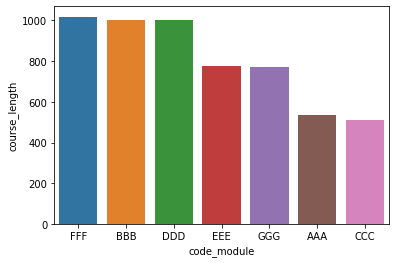

In [21]:
sns.barplot(x='code_module', y='course_length', data=course_lenght)

#### Исследуем данные третьей таблицы studentAssessment

In [22]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key3 = 'https://disk.yandex.ru/d/DYd4M5b_8RETsA'  # вписываем ссылку

# Получаем загрузочную ссылку
final_url = base_url + urlencode(dict(public_key=public_key3))
response = requests.get(final_url)
download_url = response.json()['href']

df_stud_ass = pd.read_csv(download_url)
df_stud_ass.head()

,id_assessment,id_student,date_submitted,is_banked,score
0,1752,11391,18,0,78.0
1,1752,28400,22,0,70.0
2,1752,31604,17,0,72.0
3,1752,32885,26,0,69.0
4,1752,38053,19,0,79.0


Датафрейм **df_stud_ass** содержит результаты тестов студентов. Если учащийся не отправляет работу на оценку, результат не записывается в таблицу.

In [23]:
df_stud_ass.shape

(173912, 5)

In [24]:
df_stud_ass.dtypes

id_assessment       int64
id_student          int64
date_submitted      int64
is_banked           int64
score             float64
dtype: object

In [25]:
df_stud_ass.duplicated().sum()

0

In [26]:
#  проверяем студентов, которым перезачли результаты теста

df_stud_ass.query("is_banked == 1").head()

,id_assessment,id_student,date_submitted,is_banked,score
1641,1758,603861,-1,1,61.0
1685,1758,1970390,-1,1,78.0
1690,1758,2073016,-1,1,60.0
1693,1758,2139353,-1,1,65.0
1708,1758,2358969,-1,1,68.0


In [27]:
df_stud_ass.query("is_banked == 1").id_student.nunique()

523

Всего 523 студента, которым перезачли результаты теста с прошлого семестра.
При этом date_submitted везде в таких случаях  = -1, т.е. дата сдачи ставилась за день до начала курса. Таким образом, имеем первое опровержение того, что пустые значения в date - это перезачтенные результаты. 

In [28]:
# проверка пропущенных значений в датасете

df_stud_ass.isna().sum()

id_assessment       0
id_student          0
date_submitted      0
is_banked           0
score             173
dtype: int64

В данной таблице есть незаполненные значения в колонке score, возможно, это несданные еще тесты (студент не сдал тест, хотя курс завершил), либо те, студенты, которые отменили регистрацию на курс и не стали его проходить.  
- нужно проверить date_unregistration (отмененные регистрации),
- а также посмотреть заполнена ли по ним дата (date)  


In [29]:
#посмотрим на студентов, у которых значение score не заполнено

stud_score0 = df_stud_ass.query("score == 'NaN'") \
                         .groupby(['id_student'], as_index=False)\
                         .agg({'id_assessment':'count'})
stud_score0.head()

,id_student,id_assessment
0,33666,1
1,77241,1
2,126074,1
3,136944,1
4,168243,1


In [30]:
print(stud_score0.id_student.nunique(), "студентов, у которых значение score не заполнено")

160 студентов, у которых значение score не заполнено


In [31]:
# студенты, у которых не заполнен score в результатах более одного  теста (таких студентов уже не так много)

stud_score0.query("id_assessment > 1")

,id_student,id_assessment
8,186780,2
17,260955,3
30,412731,2
49,505854,2
58,524109,2
64,542550,2
65,544930,2
67,545944,2
77,554818,3
91,578725,2


In [32]:
# посмотрим на среднее значение оценки каждого студента

df_students_avg = df_stud_ass.groupby(['id_student'], as_index=False)\
                         .agg({'score':'mean'})
df_students_avg.head()

,id_student,score
0,6516,61.800000
1,8462,87.000000
2,11391,82.000000
3,23629,82.500000
4,23698,74.444444


In [33]:
df_students_avg.score.describe()

count    23351.000000
mean        73.142603
std         15.541069
min          0.000000
25%         65.000000
50%         76.000000
75%         84.333333
max        100.000000
Name: score, dtype: float64

In [34]:
df_students_avg.score.median()

76.0

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


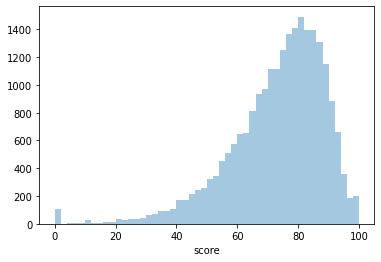

In [35]:
# посмотрим распределение средних значений оценок студентов на диаграмме

sns.distplot(df_students_avg.score, kde=False)

Видим, что распределение всех средних оценок каждого студента - близко к нормальному.  
При этом среднее значение равно 73, тогда как медиана чуть смещена в большую сторону и равна 76.  
Также наблюдаем пиковое значение, где score=0.

#### Исследуем данные четвертой таблицы studentRegistration

In [36]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key4 = 'https://disk.yandex.ru/d/lqHnH8NOZ458iw'  # вписываем ссылку

# Получаем загрузочную ссылку
final_url = base_url + urlencode(dict(public_key=public_key4))
response = requests.get(final_url)
download_url = response.json()['href']

df_stud_reg = pd.read_csv(download_url)
df_stud_reg.head()

,code_module,code_presentation,id_student,date_registration,date_unregistration
0,AAA,2013J,11391,-159.0,NaN
1,AAA,2013J,28400,-53.0,NaN
2,AAA,2013J,30268,-92.0,12.0
3,AAA,2013J,31604,-52.0,NaN
4,AAA,2013J,32885,-176.0,NaN


Датафрейм **df_stud_reg** содержит информацию о времени, когда студент зарегистрировался для прохождения курса в семестре.  

- _date_registration_ — дата регистрации студента. Это количество дней, измеренное от начала семестра (отрицательное значение означает, что студент зарегистрировался на прохождение курса за это количество дней до его начала).  
- _date_unregistration_ — дата отмены регистрации студента с предмета. У студентов, окончивших курс, это поле остается пустым.  

In [37]:
df_stud_reg.dtypes

code_module             object
code_presentation       object
id_student               int64
date_registration      float64
date_unregistration    float64
dtype: object

In [38]:
df_stud_reg.shape

(32593, 5)

In [39]:
df_stud_reg.duplicated().sum()

0

In [40]:
# посмотрим студентов и кто, сколько курсов проходил

stud_reg = df_stud_reg.query("date_unregistration == 'NaN'") \
                      .groupby(['id_student'], as_index=False) \
                      .agg({'code_module':'count'})  \
                      .sort_values('code_module', ascending=False)
stud_reg.head()

,id_student,code_module
15072,632074,3
7742,554459,3
12764,608669,3
8362,561208,3
7273,548926,3


In [41]:
# проверка пропущенных значений в датасете

df_stud_reg.isna().sum()

code_module                0
code_presentation          0
id_student                 0
date_registration         45
date_unregistration    22521
dtype: int64

In [42]:
# количество уникальных студентов в данном датафрейме, общее количество всех студентов

df_stud_reg.id_student.nunique()

28785

In [43]:
# посмотрим на количество уникальных студентов, которые закончили курс (date_unregistration незаполнено)

stud_ended = df_stud_reg.query("date_unregistration == 'NaN'").id_student.nunique() 
stud_ended

21190

Количество пустых данных по date_unregistration - показывает сколько студентов окончили курс, всего 21190 студентов.  
Количество незаполненных date_registration - может показывать, на какие предметы и какие студенты не зарегистрировались

In [44]:
# проверим значения заполненные по date_unregistration, студентов, ушедших с курса  (отмены регистраций)

stud_cancel = df_stud_reg.query("date_unregistration not in 'NaN'")
stud_cancel

,code_module,code_presentation,id_student,date_registration,date_unregistration
2,AAA,2013J,30268,-92.0,12.0
15,AAA,2013J,65002,-180.0,96.0
22,AAA,2013J,94961,-170.0,72.0
29,AAA,2013J,106247,5.0,175.0
41,AAA,2013J,129955,-197.0,135.0
...,...,...,...,...,...
32576,GGG,2014J,2338614,-23.0,58.0
32577,GGG,2014J,2342238,-45.0,74.0
32578,GGG,2014J,2357806,-128.0,73.0
32586,GGG,2014J,2608143,-45.0,48.0


In [45]:
# количество студентов с отмененной регистрацией

stud_cancel.id_student.nunique()

9082

In [46]:
# предметы, в порядке убывания, с которых чаще всего отменяли регистрацию студенты  (для зад 4 - отток)

mod_cancel = stud_cancel.groupby('code_module', as_index=False)   \
                        .agg({'id_student':'nunique'}) \
                        .rename(columns={'id_student': 'num_stud'})  \
                        .sort_values('num_stud', ascending=False)
mod_cancel 

,code_module,num_stud
1,BBB,2314
5,FFF,2249
3,DDD,2065
2,CCC,1858
4,EEE,693
6,GGG,287
0,AAA,116


In [47]:
# зависимость отмены регистрации от длительности предмета (наблюдаем линейную зависимость)

len_cour_cancel = pd.merge(course_lenght, mod_cancel, on='code_module')
len_cour_cancel

,code_module,course_length,num_stud
0,FFF,1018,2249
1,BBB,1004,2314
2,DDD,1004,2065
3,EEE,778,693
4,GGG,771,287
5,AAA,537,116
6,CCC,510,1858


In [48]:
# объединим две таблицы со студентами df_stud_ass и df_stud_reg и добавим колонку с курсом

df_students = pd.merge(df_stud_ass, df_stud_reg, on='id_student')

df_students['course'] = df_students['code_module'] + df_students['code_presentation']  # добавим колонку с курсом
df_students = df_students.drop(['code_module', 'code_presentation'], axis=1)    # удалим лишние колонки, которые слили
df_students.head()

,id_assessment,id_student,date_submitted,is_banked,score,date_registration,date_unregistration,course
0,1752,11391,18,0,78.0,-159.0,NaN,AAA2013J
1,1753,11391,53,0,85.0,-159.0,NaN,AAA2013J
2,1754,11391,115,0,80.0,-159.0,NaN,AAA2013J
3,1755,11391,164,0,85.0,-159.0,NaN,AAA2013J
4,1756,11391,212,0,82.0,-159.0,NaN,AAA2013J


In [49]:
# выведем студентов, у которых есть незаполненные значения в колонке score и с отмененной регистрацией

df_students.query("score == 'NaN' & date_unregistration not in 'NaN'").head() 

,id_assessment,id_student,date_submitted,is_banked,score,date_registration,date_unregistration,course
592,1754,260355,127,0,NaN,-186.0,170.0,AAA2013J
593,1754,260355,127,0,NaN,-156.0,-87.0,AAA2014J
1205,1752,721259,22,0,NaN,-73.0,23.0,AAA2013J
1206,1752,721259,22,0,NaN,-30.0,128.0,AAA2014J
4809,14986,33666,117,0,NaN,-23.0,139.0,BBB2013B


In [50]:
df_students.query("score == 'NaN' & date_unregistration not in 'NaN'").id_student.nunique()

73

Всего 73 студента отменили регистрацию с курса и не стали сдавать тест, поэтому логично, что колонка score в их случае будет не заполнена.

In [51]:
# выведем студентов, у которых есть незаполненные значения в колонке scorе, но курс они завершили

df_students.query("score == 'NaN' & date_unregistration == 'NaN'").head() 

,id_assessment,id_student,date_submitted,is_banked,score,date_registration,date_unregistration,course
3400,1760,2606802,180,0,NaN,-37.0,NaN,AAA2014J
5783,14988,262294,152,0,NaN,-113.0,NaN,BBB2014B
8144,14989,478317,222,0,NaN,-87.0,NaN,BBB2014B
8464,14987,484039,137,0,NaN,-53.0,NaN,BBB2013B
9193,14989,502717,216,0,NaN,-21.0,NaN,BBB2013B


In [52]:
df_students.query("score == 'NaN' & date_unregistration == 'NaN'").id_student.nunique()

105

In [53]:
# а теперь смотрим студентов, у которых есть оценки, но регистрацию в какой-то момент они отменили

df_students.query("score != 'NaN' & date_unregistration not in 'NaN'").head()

,id_assessment,id_student,date_submitted,is_banked,score,date_registration,date_unregistration,course
70,1752,65002,17,0,66.0,-180.0,96.0,AAA2013J
72,1753,65002,51,0,68.0,-180.0,96.0,AAA2013J
74,1758,65002,-1,1,66.0,-180.0,96.0,AAA2013J
76,1759,65002,-1,1,68.0,-180.0,96.0,AAA2013J
107,1752,94961,17,0,74.0,-170.0,72.0,AAA2013J


In [54]:
df_students.query("score != 'NaN' & date_unregistration not in 'NaN'").id_student.nunique()

4812

Из данных выше видно, что есть 73 студента, у которых есть незаполненные значения в колонке score - это студенты, отменившие регистрацию на курс. Также есть 105 студентов, завершивших курс, однако оценки в колонке score у них отсутствуют. И наоборот, оценки есть, но курс до конца не прошли (отменив регистрацию в какой-то момент) - достаточно много студентов - 4812 человек. 

In [55]:
# количество студентов прошедших каждый курс    (для зад 4 - по предметам)

stud_on_course = df_students.groupby(['course'], as_index=False).agg({'id_student':'nunique'})  \
                            .rename(columns={'id_student':'stud_amount'})  \
                            .sort_values(by='stud_amount', ascending=False) 
stud_on_course.head()

,course,stud_amount
7,CCC2014J,2208
16,FFF2013J,1910
18,FFF2014J,1877
5,BBB2014J,1803
3,BBB2013J,1747


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21]),
 <a list of 22 Text major ticklabel objects>)

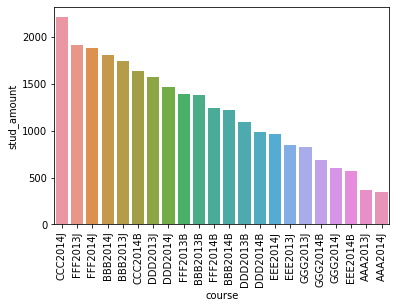

In [56]:
# можно построить график, где отображается сколько студентов прошло каждый курс

sns.barplot(x='course', y='stud_amount', data=stud_on_course)
plt.xticks(rotation=90)

In [57]:
# количество студентов отменивших регистрацию (с каких курсов больше всего уходили)

stud_cancel_course = df_students.query("date_unregistration not in 'NaN'")  \
                                .groupby(['course'], as_index=False)  \
                                .agg({'id_student':'nunique'})  \
                                .rename(columns={'id_student':'stud_amount'})  \
                                .sort_values(by='stud_amount', ascending=False)
stud_cancel_course.head()

,course,stud_amount
7,CCC2014J,795
6,CCC2014B,652
18,FFF2014J,398
9,DDD2013J,393
16,FFF2013J,370


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21]),
 <a list of 22 Text major ticklabel objects>)

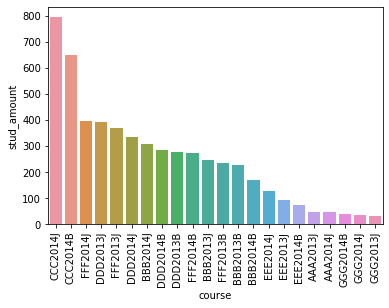

In [58]:
# можно построить график, где отображается сколько студентов отменило регистрацию с каждого курса

sns.barplot(x='course', y='stud_amount', data=stud_cancel_course)
plt.xticks(rotation=90)

/opt/tljh/user/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/tljh/user/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


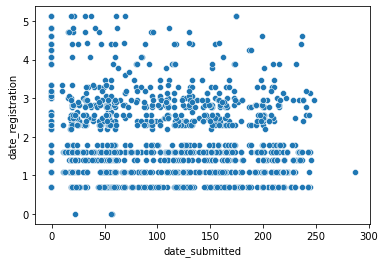

In [59]:
# диаграмма зависимости даты сдачи теста от даты регистрации

sns.scatterplot(data=df_students, x=df_students.date_submitted, y=np.log(df_students.date_registration))

Теперь проверим значения с незаполненной датой регистрации

In [60]:
# проверим что это за значения с незаполненной датой регистрации

reg_nan = df_stud_reg.loc[df_stud_reg.date_registration.isnull()]
reg_nan.head()

,code_module,code_presentation,id_student,date_registration,date_unregistration
2344,BBB,2013B,630346,NaN,NaN
2538,BBB,2013J,57369,NaN,-1.0
2759,BBB,2013J,342678,NaN,-33.0
5356,BBB,2014B,582496,NaN,-126.0
5490,BBB,2014B,607646,NaN,-38.0


In [61]:
# количество студентов с незаполненной датой регистрацией

reg_nan.id_student.nunique()

43

In [62]:
# проверяем что это за студенты, которые не регистрировались на курс, однако курс будто прошли (так как date_unregistration не заполнено)

reg_nan.query("date_unregistration == 'Nan'")

,code_module,code_presentation,id_student,date_registration,date_unregistration
2344,BBB,2013B,630346,NaN,NaN
12893,CCC,2014J,1777834,NaN,NaN
14392,DDD,2013B,2707979,NaN,NaN
14393,DDD,2013B,2710343,NaN,NaN
17559,DDD,2014B,2710343,NaN,NaN
23796,FFF,2013B,2102658,NaN,NaN


Мы видим 5 разных студентов, у которых нет  date_registration и date_unregistration. 

In [63]:
# посмотрим, есть ли эти студенты в списке тех, кому перезачли результат

lst_stud = reg_nan.query("date_unregistration == 'Nan'").id_student.unique()
lst_banked = df_stud_ass.query("is_banked == 1").id_student.unique()
for с in lst_stud:
    if с in lst_banked:
        print(с, "результат перезачли")
    else:
        print(с, "ошибка в данных")

630346 ошибка в данных
1777834 ошибка в данных
2707979 ошибка в данных
2710343 ошибка в данных
2102658 ошибка в данных


По всем 5-ти студентам нет данных по перезачету, соответственно, возможно, это какая-то ошибка в данных.

In [64]:
# количество студентов, с незаполненной датой регистрацией по каждому предмету

reg_nan.groupby('code_module', as_index=False).agg({'id_student':'count'})

,code_module,id_student
0,BBB,9
1,CCC,8
2,DDD,15
3,EEE,2
4,FFF,11


По незаполненным данным в колонке date_registration видно, что таких строк 45 и в основном, date_unregistration у таких студентов меньше 0, что показывает, что они отменили регистрацию до начала курса. (возможно, это студенты, которые куда-то перевелись ?)  
По заполненным значениям date_unregistration - видно, что отменили регистрацию 10072 раз (всего таких 9082 студента) и можно заметить, что дата регистрации у многих имеет отрицательные значения, что говорит о том, что зарегистрировались они до начала курса. Можно проверить зависимость даты регистрации от даты отмены таких студентов, чтобы понять, возможные причины. Для этого необходимо построить график распределения.

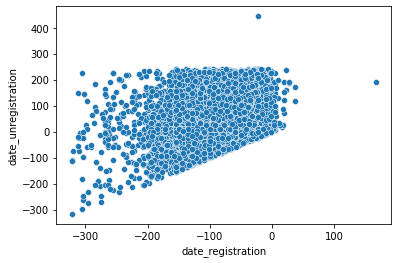

In [65]:
sns.scatterplot(data=df_stud_reg, x='date_registration', y='date_unregistration')

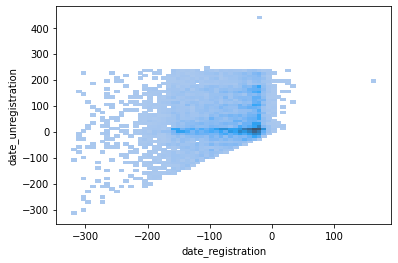

In [66]:
sns.histplot(data=stud_cancel, x='date_registration', y='date_unregistration')

На диаграмме приведена зависимость даты отмены регистрации от начальной даты регистрации. Рассматриваются только студенты, отменившие регистрацию. Прослеживается линейная зависимость. ??
Чем ближе к дате начала курса, тем плотнее распределены во времени отмены, так как ближе дата экзаменов

## Задание 1.

**Сколько студентов успешно сдали только один курс?**  
_(Успешная сдача — это зачёт по курсу на экзамене)_

In [67]:
# для этого вначале объединим датафреймы между собой

stud_marks = pd.merge(df_assessments, df_stud_ass, on='id_assessment')
stud_marks = pd.merge(stud_marks, df_stud_reg, on=['id_student', 'code_module', 'code_presentation'])
stud_marks_course =  pd.merge(stud_marks, df_courses, on=['code_module', 'code_presentation'])

stud_marks_course['course'] = stud_marks_course['code_module'] + stud_marks_course['code_presentation']  # добавим колонку с курсом

stud_marks_course.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight,id_student,date_submitted,is_banked,score,date_registration,date_unregistration,module_presentation_length,course
0,AAA,2013J,1752,TMA,19.0,10.0,11391,18,0,78.0,-159.0,NaN,268,AAA2013J
1,AAA,2013J,1753,TMA,54.0,20.0,11391,53,0,85.0,-159.0,NaN,268,AAA2013J
2,AAA,2013J,1754,TMA,117.0,20.0,11391,115,0,80.0,-159.0,NaN,268,AAA2013J
3,AAA,2013J,1755,TMA,166.0,20.0,11391,164,0,85.0,-159.0,NaN,268,AAA2013J
4,AAA,2013J,1756,TMA,215.0,30.0,11391,212,0,82.0,-159.0,NaN,268,AAA2013J


In [68]:
#  проверка на  дубли 

stud_marks_course.duplicated().sum()

0

In [69]:
# студенты, успешно сдавшие экзамены (фильтруем по типу экзамен и по количеству баллов)

one_course_passed = stud_marks_course.query("assessment_type =='Exam' and score >= 40") \
                                     .groupby(['id_student'], as_index=False) \
                                     .agg({'assessment_type' : 'count'}) \
                                     .query('assessment_type == 1')
one_course_passed.head()          #  .id_student.nunique()  - количество уникальных студентов

,id_student,assessment_type
0,23698,1
1,24213,1
2,27116,1
3,28046,1
4,28787,1


In [70]:
print(f'Ответ: {one_course_passed.id_student.nunique()} студентов успешно сдали только один курс')

Ответ: 3802 студентов успешно сдали только один курс


**3802 студентов успешно сдали только один курс**

Далее мне захотелось поглубже изучить данные и посмотреть не только количество успешно сдавших один курс, но и другие факты. :)
(Надеюсь, это не возбраняется =))

In [71]:
# проверим, кто из студентов сдал больше, чем один курс

passed_more = stud_marks_course.query("assessment_type =='Exam' and score >= 40") \
                               .groupby('id_student', as_index=False) \
                               .agg({'assessment_type' : 'count'})  \
                               .query("assessment_type > 1")  

passed_more.head()                   #.id_student.nunique()

,id_student,assessment_type
64,80329,2
66,80868,2
91,105523,2
108,123598,2
111,126394,2


In [72]:
# сколько студентов сдали больше, чем один курс

passed_more.id_student.nunique()

295

In [73]:
stud_2more = stud_marks_course.query("id_student in @passed_more.id_student")  \
           .query("assessment_type =='Exam' and score >= 40") \
           .groupby(['id_student'], as_index=False) \
           .agg({'course' : 'unique'})
stud_2more.head()

,id_student,course
0,80329,"[CCC2014J, DDD2014J]"
1,80868,"[CCC2014J, DDD2013J]"
2,105523,"[CCC2014B, DDD2013J]"
3,123598,"[CCC2014J, DDD2013J]"
4,126394,"[CCC2014B, DDD2013J]"


Все 295 найденных студента, которые сдавали более одного курса - сдавали по 2 экзамена по следующим предметам: 'CCC2014J', 'CCC2014B', 'DDD2013J', 'DDD2013B', 'DDD2014J', 'DDD2014B'.  
Все остальные студенты успешно сдали только один курс (всего 3802)

In [74]:
# студенты не сдавшие экзамены

course_notpassed = stud_marks_course.query("assessment_type =='Exam' and score < 40") \
                                     .groupby(['id_student'], as_index=False) \
                                     .agg({'assessment_type' : 'count'}) \
                                     .rename(columns={'assessment_type':'cnt'})
course_notpassed.head()       #.id_student.nunique()

,id_student,cnt
0,31173,1
1,46753,1
2,51955,1
3,52014,1
4,63566,1


In [75]:
print("Не сдали экзамен: ", course_notpassed.id_student.nunique(), "человек(a)")

Не сдали экзамен:  564 человек(a)


In [76]:
# список предметов, по которым есть несдавшие его студенты

stud_marks_course.query("id_student in @course_notpassed.id_student").code_module.unique()

array(['CCC', 'DDD', 'EEE', 'FFF', 'GGG'], dtype=object)

In [77]:
# 3 студента, не сдавших два экзамена за курс 
# как и со сдавшими два экзамена  - это все те же курсы по предметам ССС и DDD

stud_3 = course_notpassed.query("cnt > 1")
stud_3

,id_student,cnt
204,527323,2
281,558914,2
525,1068316,2


In [78]:
# посмотрим на студентов с этими id

stud_marks_course.loc[stud_marks_course.id_student == 527323].head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight,id_student,date_submitted,is_banked,score,date_registration,date_unregistration,module_presentation_length,course
75477,DDD,2013B,25334,TMA,25.0,7.5,527323,21,0,47.0,-120.0,NaN,240,DDD2013B
75478,DDD,2013B,25335,TMA,53.0,10.0,527323,61,0,45.0,-120.0,NaN,240,DDD2013B
75479,DDD,2013B,25336,TMA,81.0,12.5,527323,81,0,73.0,-120.0,NaN,240,DDD2013B
75480,DDD,2013B,25337,TMA,116.0,15.0,527323,116,0,93.0,-120.0,NaN,240,DDD2013B
75481,DDD,2013B,25338,TMA,151.0,15.0,527323,156,0,69.0,-120.0,NaN,240,DDD2013B


In [79]:
# данные, где окончательная дата сдачи теста не указана

date_is_null = stud_marks_course.loc[stud_marks_course.date.isnull()]
date_is_null.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight,id_student,date_submitted,is_banked,score,date_registration,date_unregistration,module_presentation_length,course
46190,CCC,2014B,24290,Exam,NaN,100.0,917586,234,0,98.0,-29.0,NaN,241,CCC2014B
46195,CCC,2014B,24290,Exam,NaN,100.0,925553,230,0,94.0,-232.0,NaN,241,CCC2014B
46204,CCC,2014B,24290,Exam,NaN,100.0,949548,234,0,42.0,-95.0,NaN,241,CCC2014B
46213,CCC,2014B,24290,Exam,NaN,100.0,984619,230,0,72.0,-179.0,NaN,241,CCC2014B
46218,CCC,2014B,24290,Exam,NaN,100.0,992544,234,0,94.0,-147.0,NaN,241,CCC2014B


In [80]:
# нужно проверить 'is_banked' по этим данным

date_is_null.is_banked.sum()

0

В данных с незаполненными датами нет таких студентов, которым перезачли тест с прошлого семестра, так как нет значений равных 1 в колонке 'is_banked'. Таким образом, не подтверждается предположение, что это перезачет и делаем вывод, что это скорей всего ошибка в данных (забыли проставить дату), либо студенты, которые отменили регистрацию.

In [81]:
date_is_null.query("date_unregistration == 'NaN'").head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight,id_student,date_submitted,is_banked,score,date_registration,date_unregistration,module_presentation_length,course
46190,CCC,2014B,24290,Exam,NaN,100.0,917586,234,0,98.0,-29.0,NaN,241,CCC2014B
46195,CCC,2014B,24290,Exam,NaN,100.0,925553,230,0,94.0,-232.0,NaN,241,CCC2014B
46204,CCC,2014B,24290,Exam,NaN,100.0,949548,234,0,42.0,-95.0,NaN,241,CCC2014B
46213,CCC,2014B,24290,Exam,NaN,100.0,984619,230,0,72.0,-179.0,NaN,241,CCC2014B
46218,CCC,2014B,24290,Exam,NaN,100.0,992544,234,0,94.0,-147.0,NaN,241,CCC2014B


Также среди этих данных нет студентов, отменивших регистрацию, соответственно это какая-то ошибка в данных. При этом замечено, почти у всех значение даты регистрации - отрицательное, и только 11 значений имеют дату регистрации положительную, что означает, регистрация была произведена после начала курса. Ниже можем видеть, эти 11 значений, у которых не указана окончательная дата сдачи теста, (все относятся к трем разным курсам: 2 из них по предмету СCC, один - по предмету DDD). То есть, это те студенты, которые не успели зарегистрироваться на курс до его начала. 

In [82]:
date_is_null.query("date_registration > 0")

,code_module,code_presentation,id_assessment,assessment_type,date,weight,id_student,date_submitted,is_banked,score,date_registration,date_unregistration,module_presentation_length,course
47063,CCC,2014B,24290,Exam,NaN,100.0,2665399,230,0,96.0,6.0,NaN,241,CCC2014B
53383,CCC,2014B,24290,Exam,NaN,100.0,634816,234,0,82.0,5.0,NaN,241,CCC2014B
53622,CCC,2014B,24290,Exam,NaN,100.0,440905,230,0,34.0,12.0,NaN,241,CCC2014B
54696,CCC,2014J,24299,Exam,NaN,100.0,684111,244,0,42.0,5.0,NaN,269,CCC2014J
55074,CCC,2014J,24299,Exam,NaN,100.0,687877,244,0,80.0,5.0,NaN,269,CCC2014J
56260,CCC,2014J,24299,Exam,NaN,100.0,1961938,244,0,86.0,2.0,NaN,269,CCC2014J
64878,CCC,2014J,24299,Exam,NaN,100.0,589463,244,0,82.0,23.0,NaN,269,CCC2014J
65064,CCC,2014J,24299,Exam,NaN,100.0,245600,248,0,92.0,19.0,NaN,269,CCC2014J
90459,DDD,2014J,25368,Exam,NaN,100.0,2226202,242,0,56.0,5.0,NaN,262,DDD2014J
91010,DDD,2014J,25368,Exam,NaN,100.0,58731,245,0,40.0,4.0,NaN,262,DDD2014J


In [83]:
# здесь решила посмотреть на общее количество студентов и средний балл по каждому курсу 

course_avg_score = stud_marks_course.groupby(['course'], as_index=False)  \
                                    .agg({'id_student': 'nunique', 'score': 'mean'})  \
                                    .rename(columns={'id_student':'stud_amount', 'score':'avg_score'})  \
                                    .round(2).sort_values('avg_score', ascending=False)
course_avg_score

,course,stud_amount,avg_score
14,EEE2014J,935,82.46
12,EEE2013J,827,80.63
19,GGG2013J,819,80.26
13,EEE2014B,536,79.75
20,GGG2014B,689,79.57
2,BBB2013B,1369,79.10
21,GGG2014J,604,79.08
4,BBB2014B,1205,78.97
3,BBB2013J,1710,78.92
18,FFF2014J,1843,78.72


По средним баллам за тесты можно увидеть, что курсы с самыми высокими средними баллами являются курсы по предметам EEE и GGG, они находятся в топ-5 позициях. 

## Задание 2.

**Выяви самый сложный и самый простой экзамен: найди курсы и экзамены в рамках курса, которые обладают самой низкой и самой высокой завершаемостью.**  

*_завершаемость = кол-во успешных экзаменов / кол-во всех попыток сдать экзамен_  

In [84]:
stud_marks_course.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight,id_student,date_submitted,is_banked,score,date_registration,date_unregistration,module_presentation_length,course
0,AAA,2013J,1752,TMA,19.0,10.0,11391,18,0,78.0,-159.0,NaN,268,AAA2013J
1,AAA,2013J,1753,TMA,54.0,20.0,11391,53,0,85.0,-159.0,NaN,268,AAA2013J
2,AAA,2013J,1754,TMA,117.0,20.0,11391,115,0,80.0,-159.0,NaN,268,AAA2013J
3,AAA,2013J,1755,TMA,166.0,20.0,11391,164,0,85.0,-159.0,NaN,268,AAA2013J
4,AAA,2013J,1756,TMA,215.0,30.0,11391,212,0,82.0,-159.0,NaN,268,AAA2013J


In [85]:
# проверяем: данные об экзаменах каких курсов мы имеем

stud_marks_course.query("assessment_type=='Exam'").course.unique()

array(['CCC2014B', 'CCC2014J', 'DDD2013B', 'DDD2013J', 'DDD2014B',
       'DDD2014J'], dtype=object)

Видим, что у нас нет данных по всем курсам и даже не по всем предметам, а только попали данные по предметам CCC и DDD. Соответственно, весь дальнейший анализ (касаемо экзаменов по курсу/предмету) мы проводим только по этим представленным курсам. 

In [86]:
# посмотрим количество успешных сдач по курсам

ended = stud_marks_course.query("assessment_type == 'Exam' & score >= 40")  \
                         .groupby(['course', 'id_assessment'], as_index=False)  \
                         .agg({'score': 'count'})  \
                         .rename(columns={'score': 'pass_cnt'})  \
                         .sort_values('pass_cnt')
ended

,course,id_assessment,pass_cnt
4,DDD2014B,25361,485
2,DDD2013B,25340,504
0,CCC2014B,24290,664
5,DDD2014J,25368,842
3,DDD2013J,25354,878
1,CCC2014J,24299,1019


In [87]:
# посмотрим все попытки сдать по курсам

try_pass = stud_marks_course.query('assessment_type == "Exam"')  \
                            .groupby(['course', 'id_assessment'], as_index=False)  \
                            .agg({'date_submitted': 'count'})  \
                            .rename(columns={'date_submitted': 'try_cnt'})  \
                            .sort_values('try_cnt')
try_pass

,course,id_assessment,try_cnt
4,DDD2014B,25361,524
2,DDD2013B,25340,602
0,CCC2014B,24290,747
5,DDD2014J,25368,950
3,DDD2013J,25354,968
1,CCC2014J,24299,1168


In [88]:
join_data = pd.merge(ended, try_pass, on=['course', 'id_assessment'])
join_data

,course,id_assessment,pass_cnt,try_cnt
0,DDD2014B,25361,485,524
1,DDD2013B,25340,504,602
2,CCC2014B,24290,664,747
3,DDD2014J,25368,842,950
4,DDD2013J,25354,878,968
5,CCC2014J,24299,1019,1168


In [89]:
# создадим колонку: завершаемость = кол-во успешных экзаменов / кол-во всех попыток сдать экзамен

join_data['luckily_ended'] = join_data.pass_cnt / join_data.try_cnt

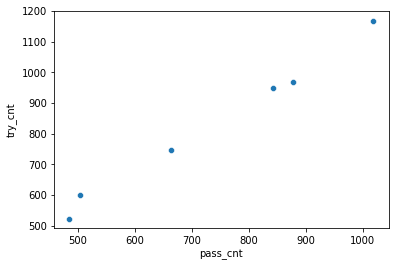

In [90]:
# построим диаграмму попытки сдачи от общего количества сданных

sns.scatterplot(data=join_data, x='pass_cnt', y='try_cnt')

In [91]:
# отсортируем по завершаемости

join_data.sort_values('luckily_ended')

,course,id_assessment,pass_cnt,try_cnt,luckily_ended
1,DDD2013B,25340,504,602,0.837209
5,CCC2014J,24299,1019,1168,0.872432
3,DDD2014J,25368,842,950,0.886316
2,CCC2014B,24290,664,747,0.888889
4,DDD2013J,25354,878,968,0.907025
0,DDD2014B,25361,485,524,0.925573


Из данных видно, что по нужным критериям отбора (экзамены по курсам и оценка выше 40) мы получили данные только по двум предметам ССС и DDD.
Самый **высокий процент завершаемости** у курса **DDD2014B** и экзамена с id **25361**, а самый **низкий** - у курса **DDD2013B** и экзамена с id **25340**. При этом наблюдается линейная зависимость и количество сданных тестов тем больше, чем больше общее количество попыток сдачи.

## Задание 3.

**По каждому предмету определи средний срок сдачи экзаменов (под сдачей понимаем последнее успешное прохождение экзамена студентом).**

In [92]:
# средний срок сдачи тестов (последнее успешное прохождение - отображается в колонке date)

avg_lastdate_pass = stud_marks_course.query("score >= 40 and date not in 'NaN'")  \
                                 .groupby(['code_module'], as_index=False) \
                                 .agg({'date' : 'mean'})  

avg_lastdate_pass     # assessment_type == 'Exam'  не учтено

,code_module,date
0,AAA,109.157068
1,BBB,105.710525
2,CCC,102.091308
3,DDD,101.458545
4,EEE,90.853473
5,FFF,167.018217
6,GGG,185.212107


В начале было решено смотреть по колонке **_date_**, ведь именно в ней должна отображаться **_окончательная дата сдачи_** (как и просят в условии) - где получены средние сроки сдач по каждому предмету. Однако потом, я поняла, что не поставила в фильтр тип - "экзамен", таким образом отобразилось среднее по всем типам тестов, а не только по экзаменам. Поэтому далее, поставив в фильтр тип "экзамен" - получила данные только по предмету DDD, по предмету ССС - данных почему-то не было. Возможно из-за того, что там встречаются незаполненные значения и они могут влиять на расчет среднего. Однако потом решила попробовать взять данные по колонке _date_submitted_.

In [93]:
# средний срок сдачи экзаменов (другой вариант)

avg_date_pass = stud_marks_course.query("assessment_type == 'Exam' and score >= 40") \
                                 .groupby(['code_module'], as_index=False) \
                                 .agg({'date_submitted' : 'mean'}) \
                                 .rename(columns={'date_submitted':'avg_term'}).round(2)

avg_date_pass

,code_module,avg_term
0,CCC,239.35
1,DDD,237.98


**Здесь мы видим, что средний срок сдачи предмета ССС - 239, а предмета DDD - 238.**

## Задание 4.

**Выяви самые популярные предметы (ТОП-3) по количеству регистраций на них.   
А также предметы с самым большим оттоком (ТОП-3).** 

In [94]:
# предметы в порядке убывания  по количеству зарегистрировавшихся студентов

stud_on_course = df_stud_reg.query("date_registration not in 'Nan'")   \
                                  .groupby('code_module', as_index=False)  \
                                  .agg({'id_student':'nunique'})  \
                                  .rename(columns={'id_student':'stud_amount'})  \
                                  .sort_values(by='stud_amount', ascending=False) 
stud_on_course

,code_module,stud_amount
1,BBB,7683
5,FFF,7387
3,DDD,5840
2,CCC,4244
4,EEE,2858
6,GGG,2525
0,AAA,712


In [95]:
# предметы в порядке убывания, с наибольшим оттоком студентов

mod_cancel = df_stud_reg.query("date_unregistration not in 'NaN'")  \
                        .groupby('code_module', as_index=False)   \
                        .agg({'id_student':'nunique'}) \
                        .rename(columns={'id_student': 'stud_amount'})  \
                        .sort_values('stud_amount', ascending=False)
mod_cancel 

,code_module,stud_amount
1,BBB,2314
5,FFF,2249
3,DDD,2065
2,CCC,1858
4,EEE,693
6,GGG,287
0,AAA,116


Поскольку в данных есть неуказанные значения по _date_registration_ (всего 45 таких строк), то было подсчитано не просто количество регистраций, а подсчитывалось количество уникальных студентов, у которых дата регистрации стоит. Отток студентов считался по тем значениям date_unregistration, которые были заполнены, также подсчитывалось количество уникальных студентов.  

Таким образом, получилось, что **топ-3** предмета с наибольшим количеством регистраций и и наибольшим количеством отмен совпадают - это предметы: BBB, FFF, DDD. Здесь видна положительная корреляция, что чем выше количество зарегистрировавшихся студентов, тем выше и количество ушедших с курса. Поэтому для оттока - логично было бы рассмотреть в процентном соотношении.

In [96]:
stud_on_course['churn_rate'] = round(mod_cancel['stud_amount'] / stud_on_course['stud_amount'] *100, 2)

stud_on_course.sort_values('churn_rate', ascending=False)

,code_module,stud_amount,churn_rate
2,CCC,4244,43.78
3,DDD,5840,35.36
5,FFF,7387,30.45
1,BBB,7683,30.12
4,EEE,2858,24.25
0,AAA,712,16.29
6,GGG,2525,11.37


Исходя из таких расчетов в процентном соотношении, видно, что уже немного другая картина.  
**ТОП-3** предметов по оттоку студентов получаются следующие: ***ССС (43,78%), DDD (35,36%), FFF (30,45%)***

## Задание 5.

**Используя pandas, в период с начала 2013 по конец 2014 выяви семестр с самой низкой завершаемостью курсов и самыми долгими средними сроками сдачи курсов.**

Завершаемость курса будем рассматривать по критериям сданного экзамена и отсутствию факта отмены регистрации.

In [97]:
# проверяем, есть ли студенты, кто сдавал экзамен, но ушел с курса

stud_marks_course.query("assessment_type=='Exam' and date_unregistration not in 'NaN'")

,code_module,code_presentation,id_assessment,assessment_type,date,weight,id_student,date_submitted,is_banked,score,date_registration,date_unregistration,module_presentation_length,course
81535,DDD,2013J,25354,Exam,261.0,100.0,425543,237,0,33.0,-39.0,232.0,261,DDD2013J


Видим, что такой студент всего один, но экзамен он в итоге не сдал (его балл равен 33), соответственно он не попадает в расчет успешных попыток, а  при большом количестве студентов его можно не убирать из выборки всех попыток сдач, так как это не особо повлияет на итоговый результат расчета завершаемости.

In [98]:
# все попытки сдать экзамены по количеству студентов в каждом семестре

term_all = stud_marks_course.query('assessment_type == "Exam" ') \
                 .groupby('code_presentation', as_index = False)  \
                 .agg({'id_student':'count'}) \
                 .rename(columns={'id_student': 'stud_all'})  \
                 .sort_values('code_presentation')
term_all

,code_presentation,stud_all
0,2013B,602
1,2013J,968
2,2014B,1271
3,2014J,2118


In [99]:
# успешные попытки сдать экзамен по семестрам

term_pass = stud_marks_course.query('assessment_type == "Exam" & score >= 40') \
                 .groupby('code_presentation', as_index = False)  \
                 .agg({'id_student':'count'})  \
                 .rename(columns={'id_student': 'stud_pass'}) \
                 .sort_values('code_presentation')
term_pass 

,code_presentation,stud_pass
0,2013B,504
1,2013J,878
2,2014B,1149
3,2014J,1861


In [100]:
# рассчитываем средний срок сдачи курса

avg_date = stud_marks_course.query('assessment_type == "Exam" & score >= 40') \
                 .groupby('code_presentation', as_index = False)  \
                 .agg({'date_submitted':'mean'})  \
                 .rename(columns={'date_submitted': 'avg_date'}).round(2)
avg_date

,code_presentation,avg_date
0,2013B,230.16
1,2013J,239.51
2,2014B,233.00
3,2014J,243.68


In [101]:
# объединяем полученные данные

merged_data = pd.merge(term_all, term_pass, on=['code_presentation'])
merged_data = pd.merge(merged_data, avg_date, on=['code_presentation'])
merged_data

,code_presentation,stud_all,stud_pass,avg_date
0,2013B,602,504,230.16
1,2013J,968,878,239.51
2,2014B,1271,1149,233.00
3,2014J,2118,1861,243.68


In [102]:
# создадим колонку: показателя завершаемости 

merged_data['lucky_ended'] = round(merged_data.stud_pass / merged_data.stud_all * 100, 2)

In [103]:
# отсортируем по завершаемости

merged_data.sort_values('lucky_ended')

,code_presentation,stud_all,stud_pass,avg_date,lucky_ended
0,2013B,602,504,230.16,83.72
3,2014J,2118,1861,243.68,87.87
2,2014B,1271,1149,233.00,90.40
1,2013J,968,878,239.51,90.70


Семестр с самыми долгими средними сроками сдачи является **2014J _(243.68 дней - средний срок сдачи)_**  
Семестр с самой низкой завершаемостью курсов является **2013B	_(83,72% - процент завершаемости курсов)_**  

## Задание 6.

Часто для качественного анализа аудитории используют подходы, основанные на сегментации.  

**Используя python, построй адаптированные RFM-кластеры студентов, чтобы качественно оценить свою аудиторию. В адаптированной кластеризации можешь выбрать следующие метрики:**  
- R - среднее время сдачи одного экзамена,  
- F - завершаемость курсов,   
- M - среднее количество баллов, получаемое за экзамен.  

**Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров.**

**Расчет метрики R - среднего времени сдачи экзамена**  
Выбираем тип - экзамен и расчитываем среднее по полю date_submitted по каждому студенту

In [104]:
# рассчитываем метрику R - среднее время сдачи экзамена 

metric_r = stud_marks_course.query('assessment_type == "Exam"') \
                            .groupby('id_student', as_index=False) \
                            .agg({'date_submitted': 'mean'}) \
                            .rename(columns={'date_submitted': 'avg_date'}).round() 

metric_r.head()

,id_student,avg_date
0,23698,243.0
1,24213,236.0
2,27116,243.0
3,28046,237.0
4,28787,243.0


In [105]:
# разброс среднего значения даты

r_dif = metric_r.avg_date.max() - metric_r.avg_date.min()
r_dif

56.0

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


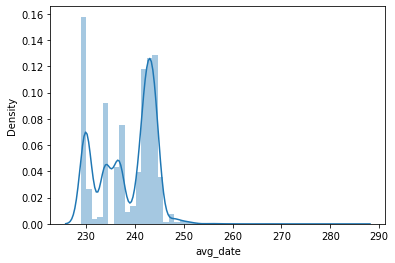

In [106]:
# строим диаграмму распределения средних значений

sns.distplot(metric_r.avg_date)

**Расчет метрики F - завершаемость курсов**  

Для того, чтобы провести расчет по завершаемости курсов по каждому студенту - необходимо решить, что мы считаем завершаемостью курсов.  

Но для начала, проверим, были ли у нас такие студенты, которые экзамен сдавали, но в итоге с курса ушли. Если таких студентов нет, то условие отмены регистрации учитывать не будем. А также посмотрим, много ли студентов, которые отменили регистрацию, но сдали тесты.

In [107]:
# студенты, сдававшие экзамен, но ушедшие с курса

stud_x = stud_marks_course.query('assessment_type == "Exam" and date_unregistration != "NaN"') \
                           .groupby('id_student', as_index=False) \
                           .agg({'score':'mean'})
stud_x

,id_student,score
0,425543,33.0


In [108]:
# получили одного студента, посмотрим, что у него с экзаменом

stud_x = stud_marks_course.query('id_student == 425543')
stud_x

,code_module,code_presentation,id_assessment,assessment_type,date,weight,id_student,date_submitted,is_banked,score,date_registration,date_unregistration,module_presentation_length,course
81532,DDD,2013J,25348,TMA,25.0,10.0,425543,34,0,64.0,-39.0,232.0,261,DDD2013J
81533,DDD,2013J,25349,TMA,53.0,12.5,425543,54,0,56.0,-39.0,232.0,261,DDD2013J
81534,DDD,2013J,25350,TMA,88.0,17.5,425543,121,0,65.0,-39.0,232.0,261,DDD2013J
81535,DDD,2013J,25354,Exam,261.0,100.0,425543,237,0,33.0,-39.0,232.0,261,DDD2013J


Поскольку такой студент (сдававший экзамен, но отменивший регистрацию) оказался один, то мы не будем его исключать из общего количества, так как он не повлияет сильно на расчеты.  
При этом видно, что у этого студента сданы тесты, но именно на экзамене он не набрал проходной балл. Еще есть странность, что дата экзамена почему-то позже даты отмены регистрации (не понятно, как он мог сдать экзамен, уйдя с курса). 

In [109]:
# студенты, успешно сдававшие тесты, но отменившие регистрацию

stud_y = stud_marks_course.query('score >= 40 and date_unregistration != "NaN"') \
                           .groupby('id_student', as_index=False) \
                           .agg({'score':'mean'})
stud_y.score.describe()

count    3991.000000
mean       70.844494
std        13.868388
min        40.000000
25%        61.000000
50%        71.500000
75%        81.000000
max       100.000000
Name: score, dtype: float64

In [110]:
# студенты, сдававшие тесты и экзамены (все попытки), и в итоге ушедшие с курса

stud_z = stud_marks_course.query('score != "NaN" and date_unregistration != "NaN"') \
                           .groupby('id_student', as_index=False) \
                           .agg({'score':'mean'})
stud_z.score.describe()

count    4333.000000
mean       64.117624
std        21.181628
min         0.000000
25%        52.250000
50%        68.000000
75%        79.666667
max       100.000000
Name: score, dtype: float64

Мы видим, достаточно большое количество студентов (3991), которые успешно сдавали тесты и не дошли до экзамена, и еще больше (4333) студентов, у которых есть попытки сдачи, но в итоге они все отменили регистрацию.  
Поэтому наверное, не стоит считать данные только по экзаменам, иначе картина завершаемости будет не полной.  
Я буду считать, что завершаемость - это доля успешно сданных экзаменов, а также тестов конкретным студентом от общего числа его попыток сдачи. Поле отмены регистрации date_unregistration не должно быть заполнено  в успешно сдавших тесты и экзамены, а в расчете всех попыток сдач - я его не учитываю, так как студенты отменившие регистрацию все равно должны учитываться (не важно, ушел он с курса, или нет).

In [111]:
# рассчитываем метрику F - завершаемость курсов, на сколько успешно студент сдавал тесты

# все попытки сдать тест по каждому студенту
all_try = stud_marks_course.query('score != "NaN"') \
                           .groupby('id_student', as_index=False) \
                           .agg({'score':'count'}) \
                           .rename(columns={'score': 'count_all'})

# успешно сданные тесты по каждому студенту

lucky_pass = stud_marks_course.query('score >= 40 and date_unregistration == "NaN"') \
                              .groupby('id_student', as_index = False)  \
                              .agg({'score':'count'})  \
                              .rename(columns={'score': 'count_pass'})

# объединим все полученные данные в одну таблицу (по полю 'id_student')

metric_f = pd.merge(all_try, lucky_pass, on=['id_student'])

# добавим столбец рассчитываемого значения завершаемости курсов (считаем на основе доли сданных тестов)

metric_f['rate_complete'] = round(metric_f.count_pass / metric_f.count_all, 2)

# выводим таблицу с метрикой F упорядоченной в порядке убывания значения завершаемости по каждому студенту

metric_f.head()

,id_student,count_all,count_pass,rate_complete
0,6516,5,5,1.0
1,11391,5,5,1.0
2,23629,4,4,1.0
3,23698,9,9,1.0
4,23798,11,11,1.0


In [112]:
# смотрим распределение значений

metric_f.rate_complete.describe()

count    19785.000000
mean         0.943447
std          0.131205
min          0.080000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: rate_complete, dtype: float64

In [113]:
# уникальные значения завершенности

metric_f.rate_complete.unique()

array([1.  , 0.8 , 0.83, 0.5 , 0.86, 0.78, 0.89, 0.71, 0.92, 0.91, 0.6 ,
       0.57, 0.67, 0.44, 0.75, 0.55, 0.81, 0.82, 0.56, 0.42, 0.63, 0.9 ,
       0.79, 0.7 , 0.61, 0.62, 0.88, 0.33, 0.69, 0.84, 0.25, 0.12, 0.27,
       0.4 , 0.64, 0.94, 0.54, 0.43, 0.45, 0.93, 0.73, 0.35, 0.85, 0.95,
       0.17, 0.36, 0.14, 0.11, 0.38, 0.23, 0.77, 0.1 , 0.29, 0.58, 0.2 ,
       0.3 , 0.96, 0.87, 0.46, 0.41, 0.18, 0.31, 0.48, 0.53, 0.22, 0.32,
       0.65, 0.19, 0.59, 0.08, 0.68, 0.47, 0.76])

Мы видим, что достаточно много студентов, которые сдавали тесты и экзамены, имеют хороший показатель завершаемости курсов. Этот показатель распределен крайне неравномерно. Но чтобы увидеть распределение всех остальных - я привела диаграмму, где значения по оси Y представлены в логарифмическом масштабе

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


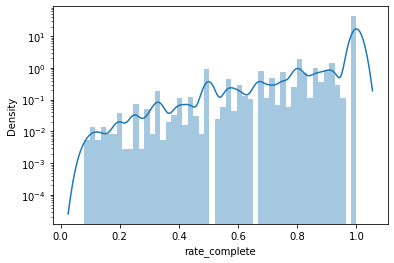

In [114]:
# посмотрим распределение значений, применив логарифмический масштаб оси Y 

sns.distplot(metric_f.rate_complete, hist_kws={"log": True})

**Расчет метрики M - среднего балла, получаемого за экзамен**   
Рассчитываем средние значения среднего балла по экзаменам каждого студента 

In [115]:
# рассчитываем метрику M - средний балл, получаемый за экзамен

metric_m = stud_marks_course.query('assessment_type == "Exam"') \
                            .groupby('id_student', as_index=False) \
                            .agg({'score': 'mean'})   \
                            .rename(columns={'score': 'avg_score'}) 
metric_m.head()

,id_student,avg_score
0,23698,80.0
1,24213,58.0
2,27116,96.0
3,28046,40.0
4,28787,44.0


Все три метрики рассчитали, теперь создадим единую таблицу, переименовываем столбцы и получаем информацию по каждому студенту

In [116]:
# сведем все метрики в один датафрейм

rfm_df = metric_r.merge(metric_m, on='id_student')
rfm_df['rate_complete'] = metric_f['rate_complete']

# и переименуем столбцы
rfm_df = rfm_df.rename(columns={'avg_date':'R_metric', 'rate_complete':'F_metric', 'avg_score':'M_metric'})
rfm_df.head()

,id_student,R_metric,M_metric,F_metric
0,23698,243.0,80.0,1.0
1,24213,236.0,58.0,1.0
2,27116,243.0,96.0,1.0
3,28046,237.0,40.0,1.0
4,28787,243.0,44.0,1.0


In [117]:
# еще раз смотрим распределение значений всех метрик

rfm_df.describe()

,id_student,R_metric,M_metric,F_metric
count,4.633000e+03,4633.000000,4633.000000,4633.000000
mean,7.256904e+05,238.464926,65.117958,0.937192
std,5.753498e+05,5.650564,20.470561,0.138768
min,2.369800e+04,229.000000,0.000000,0.100000
25%,5.011580e+05,234.000000,50.000000,1.000000
50%,5.884820e+05,241.000000,66.000000,1.000000
75%,6.463510e+05,243.000000,82.000000,1.000000
max,2.698251e+06,285.000000,100.000000,1.000000


In [118]:
# разделим значения метрик по квантилям, чтобы посмотреть, как распределяются значения

quintiles = rfm_df[['R_metric', 'F_metric', 'M_metric']].quantile([.2, .4, .6, .8]).to_dict()
quintiles

{'R_metric': {0.2: 231.0, 0.4: 237.0, 0.6: 242.0, 0.8: 244.0},
 'F_metric': {0.2: 0.89, 0.4: 1.0, 0.6: 1.0, 0.8: 1.0},
 'M_metric': {0.2: 46.200000000000045, 0.4: 60.0, 0.6: 72.0, 0.8: 84.0}}

In [119]:
# создадим словарь с границами метрик (вручную задаю границы)

{'F_metric': {0.2: 0.88, 0.4: 1, 0.6: 1, 0.8: 1},                     # разделяем показатель завершаемости
  'M_metric': {0.2: 39, 0.4: 59, 0.6: 72, 0.8: 85},                   # разделяем показатель среднего балла
  'R_metric': {0.2: 231, 0.4: 237, 0.6: 242, 0.8: 244}}               # разделяем показатель среднего срока сдачи

{'F_metric': {0.2: 0.88, 0.4: 1, 0.6: 1, 0.8: 1},
 'M_metric': {0.2: 39, 0.4: 59, 0.6: 72, 0.8: 85},
 'R_metric': {0.2: 231, 0.4: 237, 0.6: 242, 0.8: 244}}

In [120]:
# пишем функцию для присвоения значений от 1 до 5 для метрики R, М, и от 1 до 3 для метрики F

def r_score(x):
    if x <= quintiles['R_metric'][.2]:
        return 5
    elif x <= quintiles['R_metric'][.4]:
        return 4
    elif x <= quintiles['R_metric'][.6]:
        return 3
    elif x <= quintiles['R_metric'][.8]:
        return 2
    else:
        return 1

def m_score(x):
    if x <= quintiles['M_metric'][.2]:
        return 1
    elif x <= quintiles['M_metric'][.4]:
        return 2
    elif x <= quintiles['M_metric'][.6]:
        return 3
    elif x <= quintiles['M_metric'][.8]:
        return 4
    else:
        return 5    
    

def f_score(x):
    if x <= quintiles['F_metric'][.2]:
        return 1
    elif x <= quintiles['F_metric'][.4]:
        return 5
    elif x <= quintiles['F_metric'][.6]:
        return 5
    elif x <= quintiles['F_metric'][.8]:
        return 5
    else:
        return 5


In [121]:
# применяем функцию и создаем колонку с каждым показателем

rfm_df['R'] = rfm_df['R_metric'].apply(lambda x: r_score(x))
rfm_df['F'] = rfm_df['F_metric'].apply(lambda x: f_score(x))
rfm_df['M'] = rfm_df['M_metric'].apply(lambda x: m_score(x))

In [122]:
# создаем колонку RFM_Score, объединяя все три показателя

rfm_df['RFM_Score'] = rfm_df['R'].map(str) + rfm_df['F'].map(str) + rfm_df['M'].map(str)
rfm_df.head()

,id_student,R_metric,M_metric,F_metric,R,F,M,RFM_Score
0,23698,243.0,80.0,1.0,2,5,4,254
1,24213,236.0,58.0,1.0,4,5,2,452
2,27116,243.0,96.0,1.0,2,5,5,255
3,28046,237.0,40.0,1.0,4,5,1,451
4,28787,243.0,44.0,1.0,2,5,1,251


Мы получили данные в колонке RFM_Score. Подходим к финишной прямой!  
Теперь, исходя из этих обозначений разделим всех студентов на кластеры - категории. 

In [123]:
# распишем к какому типу студентов относится каждый учащийся на основании их RFM-метрики

category = {
    r'[1-2]51': 'не сдавшие, долго сдающие',
    r'[1-2]5[2-3]': 'медленно сдающие середнячки',
    r'[3-5]51': 'не сдавшие, но быстро сдающие',
    r'[3-5]5[2-3]': 'быстро сдающие середнячки',
    r'[1-2]54': 'ударники, медленно идущие к цели',
    r'[3-5]54': 'ударники, близкие к чемпионам',
    r'[1-5]11': 'не сдавшие, часто бросающие учебу студенты',
    r'[1-5]1[2-3]': 'ленивые студенты, имеющие риск уйти с курса',
    r'[1-5]1[4-5]': 'студенты с хорошими задатками, но имеющие риск уйти с курса',
    r'[1-2]55': 'отличники, но медленно идущие к цели',
    r'[3-5]55': 'чемпионы - быстро сдают и получают отличный результат'
}

rfm_df['category'] = rfm_df['R'].map(str) + rfm_df['F'].map(str) + rfm_df['M'].map(str)
rfm_df['category'] = rfm_df['category'].replace(category, regex=True)

rfm_df.head()

,id_student,R_metric,M_metric,F_metric,R,F,M,RFM_Score,category
0,23698,243.0,80.0,1.0,2,5,4,254,"ударники, медленно идущие к цели"
1,24213,236.0,58.0,1.0,4,5,2,452,быстро сдающие середнячки
2,27116,243.0,96.0,1.0,2,5,5,255,"отличники, но медленно идущие к цели"
3,28046,237.0,40.0,1.0,4,5,1,451,"не сдавшие, но быстро сдающие"
4,28787,243.0,44.0,1.0,2,5,1,251,"не сдавшие, долго сдающие"


Итак, я разделила всех студентов на категории, опираясь на их RFM_Score.  
Для того, чтобы не получилось 125 различных категорий (по количеству вариаций) - я решила объединить некоторые баллы по показателям.
За основной показатель, на который смотрела, взяла средний балл (метрика М).  
Показатель среднего времени сдачи (метрика R) - решила разбить на два промежутка: с баллами 1-2 - имеющие более длительное время сдачи и с баллами 3-5 - более раннее время сдачи.  
Значения по показателю завершаемости курсов (метрика F) распределены крайне неравномерно. Поэтому было решено взять всего 2 крайних значения (это расписала еще в функции): 5 баллов - те, кто имеют 100% завершаемость , и 1 - все остальные (но таких студентов, как было рассмотрено ранее - менее 25%). 

Всем категориям я дала название. Получились следующие категории:
 - не сдавшие, долго сдающие,  
 - медленно сдающие середнячки,  
 - не сдавшие, но быстро сдающие,  
 - быстро сдающие середнячки,  
 - ударники, медленно идущие к цели,  
 - ударники, близкие к чемпионам,  
 - не сдавшие, часто бросающие учебу студенты,  
 - ленивые студенты, имеющие риск уйти с курса,  
 - студенты с хорошими задатками, но имеющие риск уйти с курса,  
 - отличники, но медленно идущие к цели, 
 - чемпионы - быстро сдают и получают отличный результат  

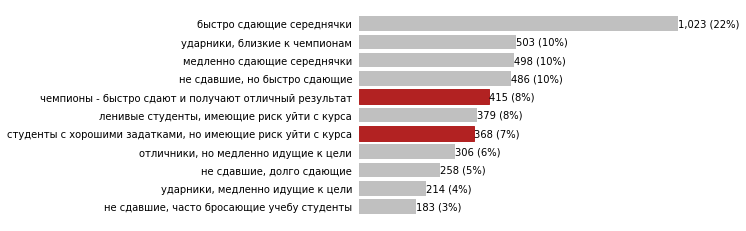

In [124]:
# теперь создадим диаграмму по категориям, в которой отметим "чемпионов", а также студентов, которые находятся в зоне риска

segments = rfm_df['category'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments)),
              segments,
              color='silver')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments)))
ax.set_yticklabels(segments.index)

for i, с in enumerate(bars):
        value = с.get_width()
        if segments.index[i] in ['чемпионы - быстро сдают и получают отличный результат',
                                 'студенты с хорошими задатками, но имеющие риск уйти с курса']:
            с.set_color('firebrick')
        ax.text(value,
                с.get_y() + с.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments.sum())),
                va='center',
                ha='left'
               )

plt.show()

Ниже - в сводной таблице представлены все категории и общее число студентов по каждой из категорий (в порядке убывания количества)

In [125]:
# сделаем итоговую таблицу, где отображены категории и количество студентов по каждой категории

df_res = rfm_df.groupby(['category'], as_index=False)  \
               .agg({'id_student': 'count'})   \
               .rename(columns={'id_student' : 'stud_amount'})  \
               .sort_values('stud_amount', ascending=False)  
df_res

,category,stud_amount
0,быстро сдающие середнячки,1023
8,"ударники, близкие к чемпионам",503
2,медленно сдающие середнячки,498
4,"не сдавшие, но быстро сдающие",486
10,чемпионы - быстро сдают и получают отличный ре...,415
1,"ленивые студенты, имеющие риск уйти с курса",379
7,"студенты с хорошими задатками, но имеющие риск...",368
6,"отличники, но медленно идущие к цели",306
3,"не сдавшие, долго сдающие",258
9,"ударники, медленно идущие к цели",214


**Итоговое резюме по студентам**  

Далее, по данным таблицы с категориями была построена диаграмма, где приведено количество студентов как в количестве, так и в процентном соотношении от общего количества.  
По итоговой диаграмме видим, что большую часть составляют студенты категории "быстро сдающие середнячки", которых 1023 человека и составляют они 22% от общего числа. (Что логично, ведь как раз середнячков обычно больше всего, значит, мы правильно дали им название). Также на диаграмме выделена цветом категория "чемпионов", которые в числе первых сдают и получают отличные оценки. Мы видим, что это достаточно обширная группа студентов (415 человек), которые составляют 8% от общего числа. Помимо чемпионов, есть категория близких к ним "ударников", которые также рано сдают и сдают достаточно хорошо, они же вовсе находятся на втором месте по количеству человек в данной категории - таких 503 человека и составляют они 10% от всех студентов.  
Помимо выделенной категории чемпионов, я выделила также цветом студентов, с хорошими задатками (они сдают тесты и экзамены на достаточно высокие баллы), но которые имеют риск уйти с курса, так как в имеющихся данных у этих студентов было обнаружено, что они не всегда заканчивают курс и у них завершаемость не равна 100%. Поэтому, зная, что эти студенты могут показать хорошие результаты, оставшись на курсе - нужно обратить больше внимания на них, возможно как-то лучше замотивировать их.  
В целом, можно отметить достаточно большой процент успешных студентов. Не сдавших студентов не так много. Самая малочисленная категория - это "не сдавшие, часто бросающие учебу студенты", таких всего 183 человека, что составляет 3% от общего количества.

In [ ]:
# хотела сделать еще другим вариантом - через pd.cut   ? ? но не получилось..

rfm_df['R_metric'] = pd.cut(rfm_df['R'], bins = 3, labels = [3,2,1])
rfm_df['F_metric'] = pd.cut(rfm_df['F'], bins = [0, 0.9, 1], labels = [1,2,3])
rfm_df['M_metric'] = pd.cut(rfm_df['M'], bins = [0,39,59,79,100], labels = [1,2,3,4,5])